<a href="https://colab.research.google.com/github/MohammedHamood/20NewsGroup/blob/main/deep_learning_for_time_series_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install chart-studio

In [ ]:


import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import optimizers
from keras.utils.vis_utils import plot_model
#from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from chart_studio import plotly as py
#import plotly.plotly as py 
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible.
#from tensorflow import set_random_seed
#from numpy.random import seed
import tensorflow as tf
tf.random.set_seed(1)
#set_random_seed(1)
#seed(1)

### Loading data

In [ ]:
train_org= pd.read_csv('train1.csv', parse_dates=['date'])
test_org = pd.read_csv('test.csv', parse_dates=['date'])

### Train set

In [ ]:
train_org.describe()

,sales
count,1300.000000
mean,654.482308
std,1162.043568
min,0.000000
25%,221.000000
50%,364.000000
75%,663.000000
max,14954.000000


In [ ]:
train_org.head()

,channel,product_name,city,date,sales
0,70 Van,Loakini 100g Chocolate 1X15,TAIF,2018-01-02,1105
1,10 Key,Loakini 100g Chocolate 1X15,Khamis,2018-01-03,0
2,70 Van,Loakini 100g Chocolate 1X15,RUH,2018-01-03,13761
3,70 Van,Loakini 100g Chocolate 1X15,Qassim,2018-01-03,7514
4,70 Van,Loakini 100g Chocolate 1X15,JED,2018-01-03,2858


### Time period of the train dataset

In [ ]:
print('Min date from train set: %s' % train_org['date'].min().date())
print('Max date from train set: %s' % train_org['date'].max().date())

Min date from train set: 2018-01-02
Max date from train set: 2018-03-04


In [ ]:
x1=train_org.product_name.unique()
z1=list(range(len(x1)))
x2=train_org.channel.unique()
z2=list(range(len(x2)))
x3=train_org.city.unique()
z3=list(range(len(x3)))

In [ ]:
test=test_org.copy()
train=train_org.copy()

In [ ]:
train['product_name'] = train['product_name'].replace(x1,z1)
train['channel'] = train['channel'].replace(x2,z2)
train['city'] = train['city'].replace(x3,z3)

In [ ]:
#test['product_name'] = test['product_name'].replace(x1,z1)
#test['channel'] = test['channel'].replace(x2,z2)
#test['city'] = test['city'].replace(x3,z3)

### Basic EDA

To explore the time series data first we need to aggregate the sales by day

In [ ]:
daily_sales = train.groupby('date', as_index=False)['sales'].sum()
channel_daily_sales = train.groupby(['channel', 'date'], as_index=False)['sales'].sum()
item_daily_sales = train.groupby(['product_name', 'date'], as_index=False)['sales'].sum()
branch_daily_sales = train.groupby(['channel','product_name', 'date'], as_index=False)['sales'].sum()

### Overall daily sales

No handles with labels found to put in legend.


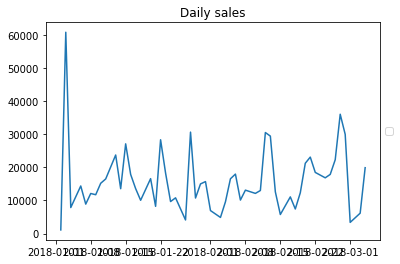

In [ ]:
plt.plot(daily_sales['date'], daily_sales['sales'])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Daily sales")
plt.show()

In [ ]:
channel_daily_sales

,channel,date,sales
0,0,2018-01-02,1105
1,0,2018-01-03,60774
2,0,2018-01-04,663
3,0,2018-01-06,3430
4,0,2018-01-07,1768
...,...,...,...
227,5,2018-02-25,6055
228,5,2018-02-26,5982
229,5,2018-02-27,3433
230,5,2018-02-28,5982


 Daily sales by store

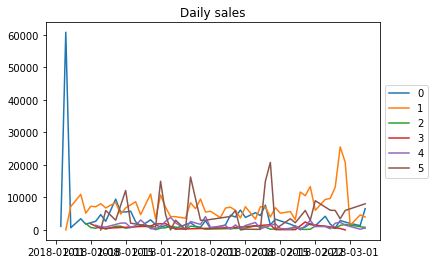

In [ ]:
for channel in channel_daily_sales['channel'].unique():
  current_channel_daily_sales = channel_daily_sales[(channel_daily_sales['channel'] == channel)]
  plt.plot(current_channel_daily_sales['date'], current_channel_daily_sales['sales'],label =  channel)
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Daily sales")
plt.show()




### Daily sales by item

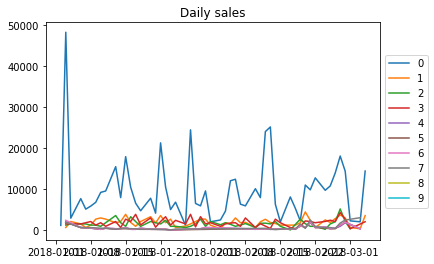

In [ ]:

for item in item_daily_sales['product_name'].unique():
  current_item_daily_sales = item_daily_sales[(item_daily_sales['product_name'] == item)]
  plt.plot(current_item_daily_sales['date'], current_item_daily_sales['sales'],label =  item)
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Daily sales")
plt.show()

In [ ]:
test1=test_org.copy()
train1=train_org.copy()

In [ ]:
train1['store'] = train1['channel'].str.cat(train1['city'],sep="_")

In [ ]:
test1['store'] = test1['channel'].str.cat(test1['city'],sep="_")

In [ ]:
x4=train1.store.unique()
z4=list(range(len(x4)))
x5=train1.product_name.unique()
z5=list(range(len(x5)))

In [ ]:
train1['store'] = train1['store'].replace(x4,z4)
train1['item'] = train1['product_name'].replace(x5,z5)
test1['store'] = test1['store'].replace(x4,z4)
test1['item'] = test1['product_name'].replace(x5,z5)

In [ ]:
train1.head()

,channel,product_name,city,date,sales,store,item
0,70 Van,Loakini 100g Chocolate 1X15,TAIF,2018-01-02,1105,0,0
1,10 Key,Loakini 100g Chocolate 1X15,Khamis,2018-01-03,0,1,0
2,70 Van,Loakini 100g Chocolate 1X15,RUH,2018-01-03,13761,2,0
3,70 Van,Loakini 100g Chocolate 1X15,Qassim,2018-01-03,7514,3,0
4,70 Van,Loakini 100g Chocolate 1X15,JED,2018-01-03,2858,4,0


In [ ]:
test1.head()

,channel,product_name,city,date,sales,store,item
0,10 Key,Loakini 100g Chocolate 1X15,JED,2018-03-05,221,13,0
1,10 Key,Loakini 100g Chocolate 1X15,Damam,2018-03-05,0,15,0
2,10 Key,Loakini 100g Chocolate 1X15,Khamis,2018-03-05,221,1,0
3,10 Key,r Rose Original Choco 150g x12,Damam,2018-03-05,1172,15,1
4,10 Key,Rose White Chocolate 150g x12,RUH,2018-03-05,342,12,2


In [ ]:
test1.drop('product_name',axis=1,inplace=True)
test1.drop('channel',axis=1,inplace=True)
test1.drop('city',axis=1,inplace=True)
train1.drop('product_name',axis=1,inplace=True)
train1.drop('channel',axis=1,inplace=True)
train1.drop('city',axis=1,inplace=True)

In [ ]:
test1.head()

,date,sales,store,item
0,2018-03-05,221,13,0
1,2018-03-05,0,15,0
2,2018-03-05,221,1,0
3,2018-03-05,1172,15,1
4,2018-03-05,342,12,2


In [ ]:
train1.head()

,date,sales,store,item
0,2018-01-02,1105,0,0
1,2018-01-03,0,1,0
2,2018-01-03,13761,2,0
3,2018-01-03,7514,3,0
4,2018-01-03,2858,4,0


In [ ]:
train1 = train1.groupby([ pd.Grouper(key='date', freq='W'),'store','item'])['sales'].sum().reset_index().sort_values('date')

In [ ]:
#train1 = train1.groupby([ pd.Grouper(key='date', freq='D'),'store','item'])['sales'].sum().reset_index().sort_values('date')

In [ ]:
train1.head(1000)

,date,store,item,sales
0,2018-01-07,0,0,1326
51,2018-01-07,14,0,221
50,2018-01-07,13,3,1465
49,2018-01-07,13,2,1465
48,2018-01-07,13,1,2344
...,...,...,...,...
695,2018-03-04,13,4,294
694,2018-03-04,13,1,98
693,2018-03-04,13,0,1282
702,2018-03-04,15,1,2051


In [ ]:
test1 = test1.groupby([ pd.Grouper(key='date', freq='W'),'store','item'])['sales'].sum().reset_index().sort_values('date')

In [ ]:
test1.head(1000)

,date,store,item,sales
0,2018-03-11,0,0,1105
36,2018-03-11,17,3,586
37,2018-03-11,18,0,221
38,2018-03-11,18,2,586
39,2018-03-11,19,3,586
...,...,...,...,...
263,2018-04-01,15,2,879
262,2018-04-01,15,1,1514
260,2018-04-01,14,3,586
267,2018-04-01,17,1,586


In [ ]:
x6=test1.store.unique()
x6

array([0, 17, 18, 19, 20, 22, 26, 29, 30, 34, 37, 43, 44, 46, 54, 16, 1,
       2, 3, 6, 7, 8, 9, 10, 12, 15, 13, 27, 21, 24, 23, 25, 28, 52, 50,
       48, 42, 38, 36, 32, 35, 11, 14, 56, 41, 5, '50 Conv_Khamis', 39,
       '20 Whole_TAIF', 55, 45, 51, '60 New_Khamis'], dtype=object)

In [ ]:
#test1.drop('Whole_TAIF', axis=0)

### Rearrange dataset so we can apply shift methods

In [ ]:
train_gp = train1.sort_values('date').groupby(['store', 'item', 'date'], as_index=False)
train_gp = train_gp.agg({'sales':['mean']})
train_gp.columns = ['store', 'item', 'date', 'sales']
train_gp.head(100)

,store,item,date,sales
0,0,0,2018-01-07,1326
1,0,0,2018-01-14,442
2,0,0,2018-01-21,663
3,0,0,2018-02-11,2210
4,0,0,2018-03-04,442
...,...,...,...,...
95,5,0,2018-02-25,884
96,5,4,2018-01-07,1323
97,5,5,2018-01-07,1029
98,5,6,2018-01-07,1323


In [ ]:
#=(train_gp['sales']-train_gp['sales'].min())/(train_gp['sales'].max()-train_gp['sales'].min())

### Transform the data into a time series problem

In [ ]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
window = 4
lag = 8
series = series_to_supervised(train_gp.drop('date', axis=1), window=window, lag=lag)
series.head(1000)

,store(t-4),item(t-4),sales(t-4),store(t-3),item(t-3),sales(t-3),store(t-2),item(t-2),sales(t-2),store(t-1),item(t-1),sales(t-1),store(t),item(t),sales(t),store(t+8),item(t+8),sales(t+8)
4,0.0,0.0,1326.0,0.0,0.0,442.0,0.0,0.0,663.0,0.0,0.0,2210.0,0,0,442,0.0,6.0,147.0
5,0.0,0.0,442.0,0.0,0.0,663.0,0.0,0.0,2210.0,0.0,0.0,442.0,0,1,293,0.0,7.0,561.0
6,0.0,0.0,663.0,0.0,0.0,2210.0,0.0,0.0,442.0,0.0,1.0,293.0,0,3,293,1.0,0.0,442.0
7,0.0,0.0,2210.0,0.0,0.0,442.0,0.0,1.0,293.0,0.0,3.0,293.0,0,4,588,1.0,0.0,1989.0
8,0.0,0.0,442.0,0.0,1.0,293.0,0.0,3.0,293.0,0.0,4.0,588.0,0,4,147,1.0,0.0,1326.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749,50.0,1.0,147.0,50.0,2.0,293.0,50.0,2.0,147.0,50.0,3.0,293.0,50,3,293,53.0,0.0,2991.0
750,50.0,2.0,293.0,50.0,2.0,147.0,50.0,3.0,293.0,50.0,3.0,293.0,50,3,147,54.0,0.0,4125.0
751,50.0,2.0,147.0,50.0,3.0,293.0,50.0,3.0,293.0,50.0,3.0,147.0,50,4,147,54.0,0.0,442.0
752,50.0,3.0,293.0,50.0,3.0,293.0,50.0,3.0,147.0,50.0,4.0,147.0,50,5,147,55.0,0.0,678.0


In [ ]:
series.astype

<bound method NDFrame.astype of      sales(t-4)  sales(t-3)  sales(t-2)  sales(t-1)  sales(t)
4        1326.0       442.0       663.0      2210.0       442
18        442.0      1989.0      1326.0       884.0      1532
19       1989.0      1326.0       884.0      1532.0      1547
20       1326.0       884.0      1532.0      1547.0      2210
21        884.0      1532.0      1547.0      2210.0      1326
..          ...         ...         ...         ...       ...
700       221.0       575.0      1238.0         0.0       575
715      1105.0      1768.0       619.0       663.0       221
716      1768.0       619.0       663.0       221.0       884
717       619.0       663.0       221.0       884.0      1105
718       663.0       221.0       884.0      1105.0      1105

[190 rows x 5 columns]>

#### Drop rows with different item or store values than the shifted columns

In [ ]:
last_item = 'item(t-%d)' % window
last_store = 'store(t-%d)' % window
series = series[(series['store(t)'] == series[last_store])]
series = series[(series['item(t)'] == series[last_item])]

#### Remove unwanted columns

In [ ]:
columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['item', 'store']]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['item', 'store']]
series.drop(columns_to_drop, axis=1, inplace=True)
series.drop(['item(t)', 'store(t)'], axis=1, inplace=True)

In [ ]:
series

,sales(t-4),sales(t-3),sales(t-2),sales(t-1),sales(t),sales(t+8)
4,1326.0,442.0,663.0,2210.0,442,147.0
18,442.0,1989.0,1326.0,884.0,1532,879.0
19,1989.0,1326.0,884.0,1532.0,1547,586.0
20,1326.0,884.0,1532.0,1547.0,2210,293.0
21,884.0,1532.0,1547.0,2210.0,1326,293.0
...,...,...,...,...,...,...
700,221.0,575.0,1238.0,0.0,575,293.0
715,1105.0,1768.0,619.0,663.0,221,2284.0
716,1768.0,619.0,663.0,221.0,884,221.0
717,619.0,663.0,221.0,884.0,1105,221.0


In [ ]:
labels_col = 'sales(t+%d)' % lag
labels = series[labels_col]
labels_col

'sales(t+8)'

In [ ]:
labels

4       147.0
18      879.0
19      586.0
20      293.0
21      293.0
        ...  
700     293.0
715    2284.0
716     221.0
717     221.0
718    3875.0
Name: sales(t+8), Length: 190, dtype: float64

In [ ]:
series = series.drop(labels_col, axis=1)

### Train/validation split

In [ ]:
# Label


X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.2, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
X_train.head()

Train set shape (152, 5)
Validation set shape (38, 5)


,sales(t-4),sales(t-3),sales(t-2),sales(t-1),sales(t)
352,2344.0,3516.0,293.0,879.0,1172
48,11713.0,5083.0,663.0,1238.0,3698
339,221.0,884.0,869.0,3094.0,3536
298,2210.0,3094.0,2593.0,2210.0,2195
299,3094.0,2593.0,2210.0,2195.0,1547


In [ ]:
series

,sales(t-4),sales(t-3),sales(t-2),sales(t-1),sales(t)
4,1326.0,442.0,663.0,2210.0,442
18,442.0,1989.0,1326.0,884.0,1532
19,1989.0,1326.0,884.0,1532.0,1547
20,1326.0,884.0,1532.0,1547.0,2210
21,884.0,1532.0,1547.0,2210.0,1326
...,...,...,...,...,...
700,221.0,575.0,1238.0,0.0,575
715,1105.0,1768.0,619.0,663.0,221
716,1768.0,619.0,663.0,221.0,884
717,619.0,663.0,221.0,884.0,1105


In [ ]:
series

In [ ]:
Y_train

In [ ]:
err

### MLP for Time Series Forecasting

* First we will use a Multilayer Perceptron model or MLP model, here our model will have input features equal to the window size.
* The thing with MLP models is that the model don't take the input as sequenced data, so for the model, it is just receiving inputs and don't treat them as sequenced data, that may be a problem since the model won't see the data with the sequence patter that it has.
* Input shape **[samples, timesteps]**.

In [ ]:
epochs = 10
batch = 50
lr = 0.01
adam = optimizers.Adam(lr)

AttributeError: ignored

In [ ]:
model_mlp = Sequential()
model_mlp.add(Dense(2, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mse', optimizer=adam)
model_mlp.summary()

In [ ]:
mlp_history = model_mlp.fit(X_train.values, Y_train, validation_data=(X_valid.values, Y_valid), epochs=epochs, verbose=2)

In [ ]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

In [ ]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=5, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(3, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=adam)
model_cnn.summary()

In [ ]:
cnn_history = model_cnn.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

### LSTM for Time Series Forecasting



In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(2, input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=adam)
model_lstm.summary()

In [ ]:
lstm_history = model_lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

### Comparing models

In [ ]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True,figsize=(22,12))
ax1, ax2 = axes[0]
ax3, ax4 = axes[1]

ax1.plot(mlp_history.history['loss'], label='Train loss')
ax1.plot(mlp_history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('MLP')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE')

ax2.plot(cnn_history.history['loss'], label='Train loss')
ax2.plot(cnn_history.history['val_loss'], label='Validation loss')
ax2.legend(loc='best')
ax2.set_title('CNN')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MSE')

ax3.plot(lstm_history.history['loss'], label='Train loss')
ax3.plot(lstm_history.history['val_loss'], label='Validation loss')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('MSE')

plt.show()

#### MLP on train and validation

In [ ]:
from sklearn.metrics import r2_score

mlp_train_pred = model_mlp.predict(X_train.values)
mlp_valid_pred = model_mlp.predict(X_valid.values)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, mlp_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, mlp_valid_pred)))



#### CNN on train and validation

In [ ]:
cnn_train_pred = model_cnn.predict(X_train_series)
cnn_valid_pred = model_cnn.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_valid_pred)))

#### LSTM on train and validation

In [ ]:
lstm_train_pred = model_lstm.predict(X_train_series)
lstm_valid_pred = model_cnn.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, lstm_valid_pred)))

In [ ]:
lstm_valid_pred-Y_valid


In [ ]:
ax1.plot(mlp_history.history['loss'], label='Train loss')
ax1.plot(mlp_history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('MLP')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE')